In [1]:
import numpy as np
import os
import pickle
from datasets.XP2 import Xp2Dataset
from datasets.utils import plot_on_topomap, select_grid_results_by_metric, plot_channel_coefficients
from models.efp import mh_grid_search, mh_common_model
import pandas as pd

import seaborn as sns

/home/riccardo/Projects/EEG-fMRI_fusion/models/clustering.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
base_folder = '/home/riccardo/MHdatasets'
stockwell_folder = '/media/storage1/stockwells'
out_folder = '/home/riccardo/MHdatasets/saves'
roi_str =  'sma'
root = os.path.join(base_folder,'XP2')
window_type='kazemi'
gamma=15
fmax = 60
n_bands = 12
workers = 15

dataset_unibands = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_uniband_a{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset_unibands.get_eeg_data(False)
shared_bands = dataset_unibands.get_dataset_shared_bands(fmax=fmax, num_bands=n_bands)
dataset_unibands.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=shared_bands,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type,
                                            )

Effective window size : 10.240 (s)
Starting workers and distributing tasks...


Preparing features and targets...: 100%|██████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1026.24it/s]


In [3]:
delay_time_seconds = 12
target_str = f'target_{roi_str}'
default_subject=1
subject=default_subject
test_ratio=.2
regularization_grid_search=50
overwrite=True

In [4]:
all_grid_search_results_unibands, all_models_unibands, grouped_unibands = mh_grid_search(
    dataset_unibands, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

In [5]:
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()

grouped_corr.sort_values('pearson r test', ascending=False).iloc[:10]

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,subject
channel,,,,,,,,,
CPz,0.334982,0.047810,1.071104,1.052926,-0.082803,3.807686,-5.363151,0.177602,20.878049
Pz,0.281876,0.041172,1.088421,1.072117,-0.111533,3.997872,-13.894005,0.123319,20.878049
CP1,0.281594,0.037650,1.097266,1.082417,-0.122904,3.479974,-6.046245,0.189765,20.878049
P1,0.280671,0.043061,1.081144,1.064291,-0.099343,3.914963,-5.523015,0.177352,20.878049
POz,0.275877,0.092955,1.103078,1.086597,-0.128730,4.642472,-7.542355,0.131675,20.878049
CP2,0.265269,0.069287,1.083520,1.064105,-0.091330,3.964495,-6.438658,0.137024,20.878049
P3,0.265134,0.072309,1.133738,1.117098,-0.153547,3.766933,-5.995808,0.149274,20.878049
PO4,0.263366,0.080518,1.108199,1.087859,-0.117129,3.719445,-6.184472,0.169012,20.878049
CP3,0.259202,0.101379,1.081312,1.063011,-0.095322,3.708428,-6.262420,0.156312,20.878049


Using order based on dataframe channel info


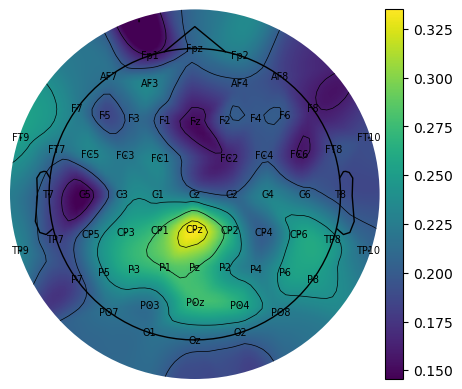

In [6]:
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()
plot_on_topomap(grouped_corr['pearson r test'], dataset_unibands[0])

Subjects:
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(20), np.int64(26), np.int64(36), np.int64(37), np.int64(39), np.int64(43)]
len: 15, 34.1% of the total.
Max mean correlation channel: CP1
Using order based on dataframe channel info


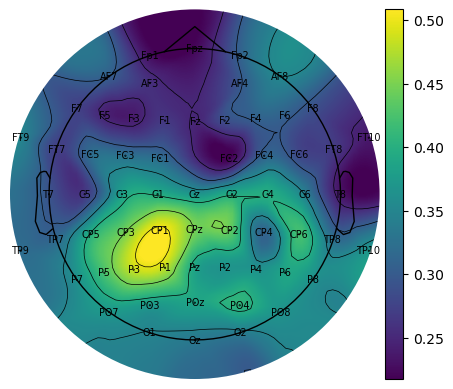

In [7]:
included_subjects_uniband, channel_name_uniband = select_grid_results_by_metric(all_grid_search_results_unibands, dataset_unibands, corr_cutoff = 0.45, selection_metric = 'pearson val') 

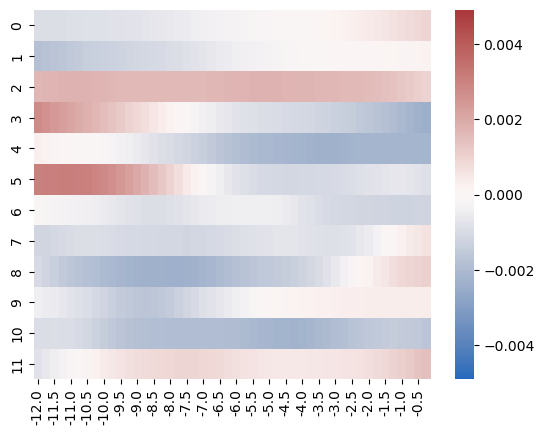

In [8]:
plot_channel_coefficients(included_subjects_uniband, dataset_unibands, 'CPz', all_models_unibands, n_bands=n_bands)

In [9]:
interesting_electrodes = ['CPz']

In [10]:
savefile = f'{out_folder}/full_dataset_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if not os.path.exists(savefile):
    everything_results = {}
else:
    everything_results = pickle.load(open(savefile, 'rb'))
    
accepted_indexes = []
for s, subj in enumerate(dataset_unibands.dataset):
    if subj['mh_features'].shape[-1] == subj[target_str].shape[-1]:
        accepted_indexes.append(s)
valid_samples = dataset_unibands.get_subsample(accepted_indexes)

for channel in interesting_electrodes:
    if channel not in everything_results:
        common_model_results, _ = mh_common_model(valid_samples, None, channel, target_str)
        everything_results[channel] = common_model_results
pickle.dump(everything_results, open(savefile, 'wb'))


full_dataset_results = []
for electrode, res in everything_results.items():
    for r in res:
        r['electrode'] = electrode
    full_dataset_results.extend(res)
full_dataset_results = pd.DataFrame(full_dataset_results)
full_dataset_results

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,electrode
0,0.266043,2.092394e-21,0.927604,0.929107,0.069388,0.953353,0.043595,0.221032,CPz
1,0.210627,8.054886e-14,0.885141,0.922235,0.039116,0.955987,0.040476,0.214320,CPz
2,0.238743,1.988747e-17,0.946486,0.945424,0.055638,0.957030,0.039059,0.212622,CPz
3,-0.042671,1.344173e-01,1.078438,1.081179,-0.083926,0.949232,0.044788,0.226221,CPz
4,0.136670,1.473083e-06,1.004473,0.997879,0.008671,0.953047,0.043055,0.222209,CPz
5,0.260467,1.486584e-20,0.964954,0.952835,0.059131,0.968376,0.027507,0.191537,CPz
6,0.378749,2.625171e-43,0.847530,0.873105,0.100548,0.961571,0.034053,0.205612,CPz
7,0.329538,1.355862e-32,0.913712,0.913665,0.086382,0.964039,0.031587,0.200232,CPz
8,0.330975,7.012614e-33,0.891127,0.898864,0.093332,0.960485,0.035279,0.208698,CPz
9,-0.162572,9.540926e-09,1.116219,1.118801,-0.121389,0.955197,0.039755,0.217412,CPz


<Axes: xlabel='electrode', ylabel='pearson r test'>

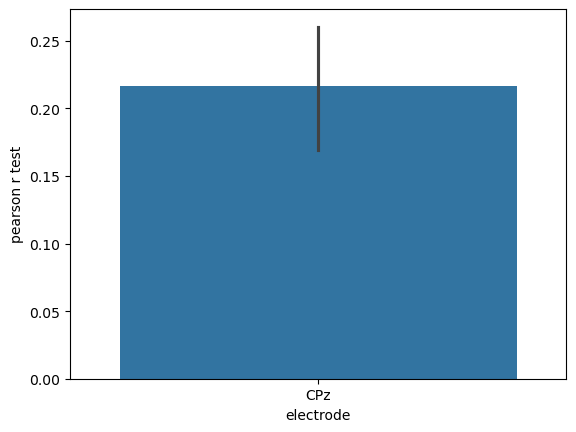

In [11]:
sns.barplot(data=full_dataset_results, x='electrode', y='pearson r test')

In [12]:
full_dataset_results.to_pickle('SMA_12_bars.pickle')

In [13]:
np.array(full_dataset_results[full_dataset_results['electrode'] == 'CPz']['pearson r test'])

array([ 0.26604315,  0.21062701,  0.23874253, -0.042671  ,  0.13667045,
        0.260467  ,  0.37874892,  0.32953804,  0.33097467, -0.16257244,
        0.09242936,  0.42738234,  0.27923796,  0.27452606,  0.22503108,
        0.20775402,  0.17488987,  0.32909489, -0.01747718,  0.26790859,
        0.3060261 ,  0.03124543,  0.21525555,  0.12495207,  0.02835124,
        0.01732997,  0.37917951,  0.18415795,  0.28455942,  0.09579442,
        0.07588379,  0.11805819,  0.37518224,  0.1597103 ,  0.32765713,
        0.4387781 ,  0.47163629,  0.37873733,  0.10781251,  0.2034424 ,
        0.34304282])